Processing the data to feed into the model

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download human-protein-atlas-image-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
human-protein-atlas-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
! unzip human-protein-atlas-image-classification

Archive:  human-protein-atlas-image-classification.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2

import imageio
from imgaug import augmenters as iaa
from tqdm import tqdm

import tensorflow as tf
sns.set()

import os
print(os.listdir("../content"))

import warnings
warnings.filterwarnings("ignore")

['.config', 'sample_submission.csv', 'model_plot.png', 'train.csv', 'human-protein-atlas-image-classification.zip', 'kaggle.json', 'test', 'train', 'sample_data']


In [4]:
INPUT_SHAPE = (299,299,12)
BATCH_SIZE = 32

In [5]:
path_to_train = '/content/train/'
data = pd.read_csv('/content/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

We've formed a numpy array of dictionaries, each dictionary holding two values:
1. Path of the image [Not including the colors, only the absolute path]
2. Classes of proteins in the image

In [6]:
train_dataset_info

array([{'path': '/content/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': '/content/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': '/content/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': '/content/train/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])},
       {'path': '/content/train/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])},
       {'path': '/content/train/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}],
      dtype=object)

Splitting the data into Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.2, random_state=42)

### Create datagenerator
- It is a helper class that is used to generate batches of training input into our model

In [8]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 12
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28)) # Creating label tensors for each batch where all 28 values are originally zero
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1 # Change those values to one which are present in the image
            yield batch_images, batch_labels
            
    # We club the four color channels into one image and that to our set. This can be seen below where we visualise the first five images in our set
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image1 = np.stack((R, R, R),-1)
        image2 = np.stack((G, G, G),-1)
        image3 = np.stack((B, B, B),-1)
        image4 = np.stack((Y, Y, Y),-1)
        
        image1 = cv2.resize(image1, (shape[0], shape[1])) # resizing the image
        image1 = np.divide(image1, 255) # Normalising the image
        image2 = cv2.resize(image2, (shape[0], shape[1])) # resizing the image
        image2 = np.divide(image2, 255) # Normalising the image
        image3 = cv2.resize(image3, (shape[0], shape[1])) # resizing the image
        image3 = np.divide(image3, 255) # Normalising the image
        image4 = cv2.resize(image4, (shape[0], shape[1])) # resizing the image
        image4 = np.divide(image4, 255) # Normalising the image
        
        im = np.concatenate((image1, image2, image3, image4), -1)
        
        return im 
                
    # Random augmentation based modification. This means each image appended to our set is rotated or flipped by some degree if augmentation is set to True which it is.
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

### Create model
 - Tools - Keras and Tensorflow

In [34]:
from imgaug.imgaug import flatten
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import backend as K



def create_model(input_shape, n_out):
    
    input_tensor = Input(shape=input_shape)
    # Hacer el split
    # tensor, número de splits, eje sobre el que se separa
    canal_1, canal_2, canal_3, canal_4 = tf.split (input_tensor, 4, -1)
    print (canal_1.shape)

    pretrain_model = InceptionV3(
        include_top=False, 
        weights='imagenet', 
        input_shape=(canal_1.shape[1], canal_1.shape[2], canal_1.shape[3]))   
    
    x1 = pretrain_model(canal_1)
    x2 = pretrain_model(canal_2)
    x3 = pretrain_model(canal_3)
    x4 = pretrain_model(canal_4)
    
    x = tf.keras.layers.Concatenate()([x1, x2, x3, x4])
    print(x.shape)
    x = Conv2D(1024, kernel_size=(1,1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Conv2D(1024, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = GlobalAveragePooling2D()(x)
    #x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [27]:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,3))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('AUC')
    ax[1].plot(history.epoch, history.history["auc_1"], label="Train AUC")
    ax[1].plot(history.epoch, history.history["val_auc_1"], label="Validation AUC")
    #ax[2].set_title('acc')
    #ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    #ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    #ax[2].legend()

In [35]:
K.clear_session()

model = create_model(
    input_shape=(299,299,12), 
    n_out=28)

model.summary()

(None, 299, 299, 3)
(None, 8, 8, 8192)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 1  0           []                               
                                2)]                                                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 299, 299, 3  0           ['input_1[0][0]']                
                                ),                                                                
                                 (None, 299, 299, 3                                               
                                ),                                                                
                                 (None, 299, 299, 3    

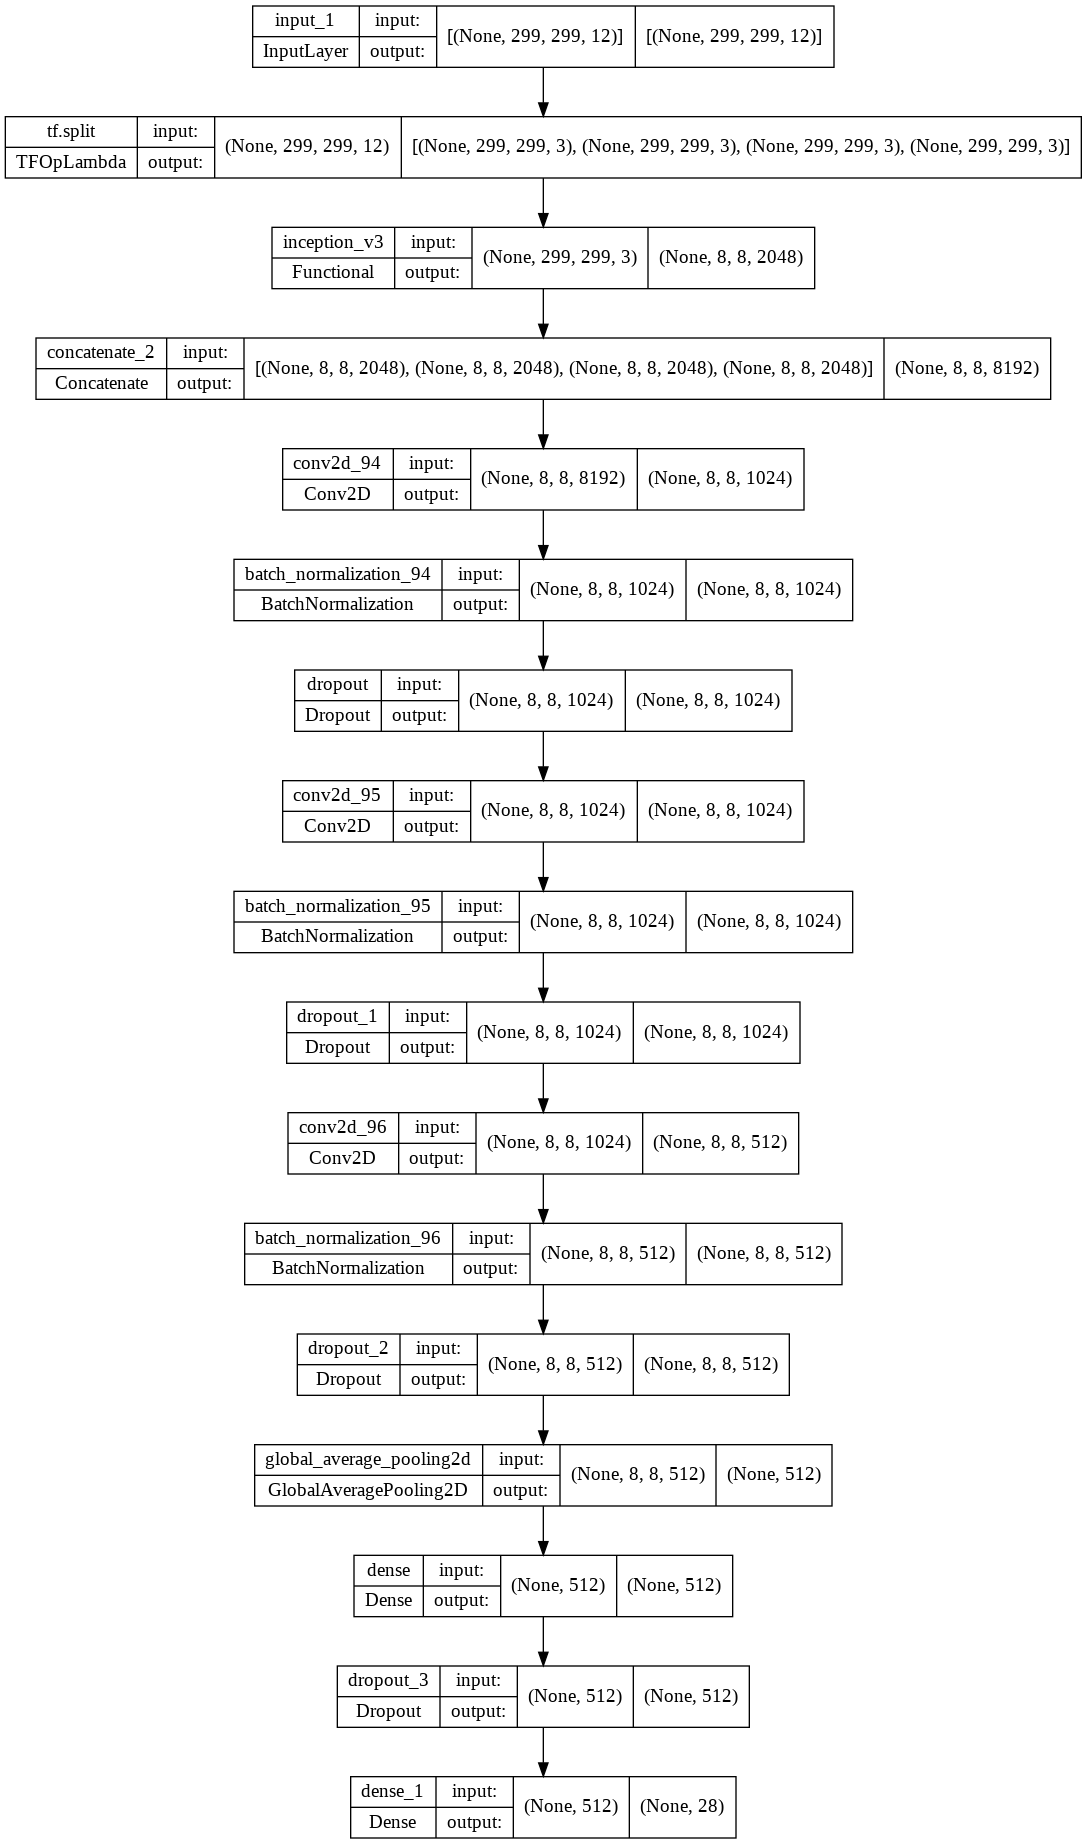

In [36]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image.open('model_plot.png')

In [13]:
train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

In [14]:
train_generator

<generator object data_generator.create_train at 0x7fd64e15b3d0>

In [24]:
!pip install tensorflow-addons==0.8.3

     |████████████████████████████████| 1.0 MB 8.2 MB/s 


In [25]:
import tensorflow_addons as tfa

checkpointer = ModelCheckpoint(
    '/kaggle/working/InceptionResNetV2.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = data_generator.create_train(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False

model.compile(
    loss=tf.keras.losses.BinaryFocalCrossentropy(),  
    optimizer=Adam(1e-4),
    metrics=[keras.metrics.AUC(multi_label=True)])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=15, 
    verbose=1,
    callbacks=None)

Epoch 1/15
100/100 [==============================] - 199s 2s/step - loss: 0.0498 - auc_1: 0.6204 - f1_score: 0.1038 - val_loss: 0.0582 - val_auc_1: 0.5959 - val_f1_score: 0.0846
Epoch 2/15
100/100 [==============================] - 167s 2s/step - loss: 0.0441 - auc_1: 0.6965 - f1_score: 0.1321 - val_loss: 0.0482 - val_auc_1: 0.6514 - val_f1_score: 0.1012
Epoch 3/15
100/100 [==============================] - 162s 2s/step - loss: 0.0419 - auc_1: 0.7260 - f1_score: 0.1507 - val_loss: 0.0413 - val_auc_1: 0.6908 - val_f1_score: 0.1490
Epoch 4/15
100/100 [==============================] - 163s 2s/step - loss: 0.0404 - auc_1: 0.7484 - f1_score: 0.1639 - val_loss: 0.0397 - val_auc_1: 0.7137 - val_f1_score: 0.1555
Epoch 5/15
100/100 [==============================] - 167s 2s/step - loss: 0.0395 - auc_1: 0.7706 - f1_score: 0.1810 - val_loss: 0.0395 - val_auc_1: 0.7026 - val_f1_score: 0.1512
Epoch 6/15
100/100 [==============================] - 167s 2s/step - loss: 0.0382 - auc_1: 0.8163 - f1_sc

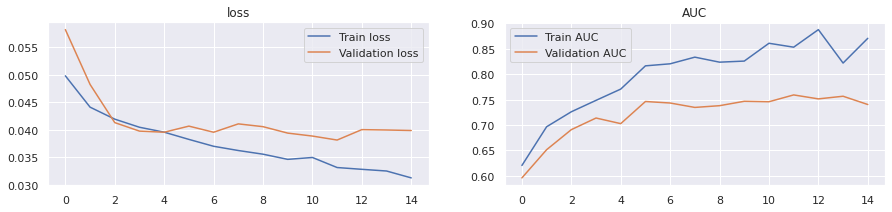

In [28]:
show_history(history)

In [30]:
save_history = np.stack ((history.epoch, history.history['loss'], history.history['val_loss'], history.history['auc_1'], history.history['val_auc_1']))
np.savetxt('Resultados_Entrenamiento_Modelo_4C_5_GAP_InceptionV3.txt', save_history)